In [1]:
import os
import glob

# Found file corresponding to this W&B run with: `grep "3pzwny4n" outputs/*/args.json`
model_folder = '../outputs/crepe-20211129-122548'

model_paths = glob.glob(os.path.join(model_folder, '*'))

In [2]:
import sys
sys.path.append('/home/jxm3/research/transcription/contrastive-pitch-detection')

In [3]:
from models.bytedance import Bytedance_Regress_pedal_Notes
from models.contrastive import ContrastiveModel

min_midi = 21
max_midi = 108
def get_model():
    num_output_nodes = 256 # contrastive embedding dim
    out_activation = None
    
    model = Bytedance_Regress_pedal_Notes(
        num_output_nodes, out_activation, tiny=False
    )
    
    return ContrastiveModel(model, min_midi, max_midi, num_output_nodes)

In [4]:
import glob
import natsort
import os
import torch

model_paths = glob.glob(os.path.join(model_folder, '*'))

model_path = natsort.natsorted(model_paths)[-2]
print('loaded model from:', model_path)

model = get_model()
model.load_state_dict(torch.load(model_path)['model'])

loaded model from: ../outputs/crepe-20211129-122548/84_epochs.pth


<All keys matched successfully>

In [5]:
# from dataloader.nsynth import load_nsynth
# dataset = load_nsynth('test', 'keyboard')

from dataloader.nsynth_chords import load_nsynth_chords
dataset = load_nsynth_chords('test')

print('loaded', len(dataset), 'tracks')

import random
random.shuffle(dataset)

loaded 993 tracks


In [6]:
import numpy as np
from utils.misc import midi_vals_to_categorical, hz_to_midi_v

batch_size = 256

min_midi = 21
max_midi = 108

x = []
y = []
all_midis = []

for i in range(batch_size):
    track = dataset[i]
    start_idx = 0
    end_idx = 16_000
    #
    audio = torch.tensor(track.waveform[start_idx : end_idx], dtype=torch.float32)
    x.append(audio)
    #
    frequencies = track.get_frequencies_from_offset(start_idx, end_idx)
    midis = np.rint(hz_to_midi_v(frequencies))
    all_midis.append(list(midis))
    categorical = midi_vals_to_categorical(midis, min_midi, max_midi)
    y.append(torch.tensor(categorical, dtype=torch.float32))
x = torch.stack(x)
y = torch.stack(y)
print('loaded audio batch of shape:', x.shape, 'with labels', y.shape)

loaded audio batch of shape: torch.Size([256, 16000]) with labels torch.Size([256, 88])


<AxesSubplot:ylabel='Count'>

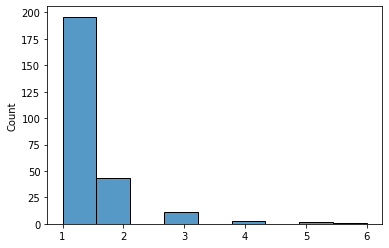

In [7]:
import seaborn as sns
sns.histplot(y.sum(1)) # validation set chord distribution (by num. notes)

In [8]:
from IPython.display import Audio
Audio(data=x[0], rate=16000)

In [11]:
audio_embeddings = model(x)
note_labels = y

batch_size, num_notes = note_labels.shape
assert num_notes == model.num_labels
chord_embeddings = model.encode_note_labels(note_labels)
assert chord_embeddings.shape == audio_embeddings.shape
# Normalize embeddings and compute logits.
normalized_audio_embeddings = audio_embeddings / torch.norm(audio_embeddings, p=2, dim=1, keepdim=True)
normalized_chord_embeddings = chord_embeddings / torch.norm(chord_embeddings, p=2, dim=1, keepdim=True)
unscaled_audio_to_chord_sim = torch.matmul(normalized_audio_embeddings, normalized_chord_embeddings.T)
audio_to_chord_sim = unscaled_audio_to_chord_sim * torch.exp(model.temperature)
chord_to_audio_sim = audio_to_chord_sim.T

logits = unscaled_audio_to_chord_sim

# Compute labels when there may be duplicates.
labels = (note_labels[:,None] == note_labels).all(2).type(torch.float32)
labels = labels / labels.sum(1)
# Compute loss across both axes.
loss_a = torch.nn.functional.cross_entropy(audio_to_chord_sim, labels)
loss_n = torch.nn.functional.cross_entropy(chord_to_audio_sim, labels.T)
loss = (loss_a + loss_n)/2
loss

tensor(2.1116, grad_fn=<DivBackward0>)

In [12]:
model.temperature, torch.exp(model.temperature)

(Parameter containing:
 tensor(4.7807, requires_grad=True),
 tensor(119.1935, grad_fn=<ExpBackward0>))

In [13]:
import functools
softmax = functools.partial(torch.nn.functional.softmax, dim=1)

AxesSubplot(0.125,0.125;0.62x0.755)


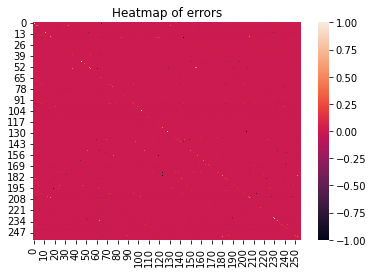

In [14]:
y_pred = softmax(audio_to_chord_sim).detach()
y_true = labels.detach()
A = sns.heatmap(y_true-y_pred, vmin=-1, vmax=1, )
A.set(title='Heatmap of errors')
print(A)

# Error analysis (val set)

Where are most of the errors coming from?

In [54]:
import collections
collections.Counter([len(n) for n in [((r.nonzero()[0]+min_midi).tolist()) for r in y]])

Counter({1: 256})

In [80]:
y_errors = ((y_true - y_pred) **2).numpy()
y_notes = np.array([(r.nonzero()[0]+min_midi).tolist() for r in y])
# print(y_notes)
#import pandas as pd
#val_err_df = pd.DataFrame(y_errors, columns=y_notes, index=y_notes)
#val_err_df
# val_err_df.sort_values(by='error_sum')

_i=0
for note, row in zip(y_notes, y_errors):
    if row.sum() < 0.01:
        print(f'{note}\tgood\t({row.sum():.2f})')
    else:
        bad_idxs = (row > 0.01).nonzero()
        print(note, f'\tbad\t({row.sum():.2f})', 'mispredictions:', y_notes[bad_idxs].tolist())

[102]	good	(0.00)
[58] 	bad	(1.95) mispredictions: [[58], [58]]
[25]	good	(0.00)
[38] 	bad	(0.53) mispredictions: [[38], [26], [26], [38], [26], [26], [38], [26]]
[36]	good	(0.00)
[45]	good	(0.00)
[63]	good	(0.00)
[27]	good	(0.00)
[26]	good	(0.00)
[66]	good	(0.00)
[35]	good	(0.00)
[103] 	bad	(0.74) mispredictions: [[103], [55], [55]]
[97]	good	(0.00)
[83] 	bad	(0.02) mispredictions: []
[58]	good	(0.00)
[41]	good	(0.00)
[94] 	bad	(0.62) mispredictions: [[58], [94], [58], [94]]
[82] 	bad	(1.08) mispredictions: [[82], [82], [82], [82], [82], [82], [70]]
[75] 	bad	(1.07) mispredictions: [[63], [75], [75], [63], [63]]
[67]	good	(0.00)
[73]	good	(0.00)
[31]	good	(0.00)
[40]	good	(0.00)
[26]	good	(0.00)
[72]	good	(0.00)
[36]	good	(0.00)
[63]	good	(0.01)
[58]	good	(0.00)
[48]	good	(0.00)
[48]	good	(0.00)
[50]	good	(0.00)
[53]	good	(0.00)
[45]	good	(0.00)
[38]	good	(0.00)
[40]	good	(0.00)
[85]	good	(0.00)
[35]	good	(0.00)
[62] 	bad	(0.15) mispredictions: [[62], [62], [62]]
[62]	good	(0.00)
[66]

# Investigating train/val difference

Why is there such a big difference between the train and validation loss? Clearly, the heatmap above is pretty bad. But what does it look like for the training data?

In [82]:
from generator import AudioDataGenerator
g = AudioDataGenerator(
        [], 16000, float('inf'),
        randomize_train_frame_offsets=True,
        batch_size=256,
        augmenter=None,
        normalize_audio=False,
        label_format='categorical',
        min_midi=21, max_midi=108,
        sample_rate=16000,
        batch_by_track=False,
        num_fake_nsynth_chords=1000,
    )

Replacing 0 tracks with 1000 fake NSynth chords
--> MusicDataLoader loading dataset nsynth_keyboard_train


Resampling tracks: 100%|██████████| 51821/51821 [00:00<00:00, 1482161.31it/s]


TrackFrameSampler loaded 4000 frames


In [83]:
x_train, y_train = g[0]

In [ ]:
audio_embeddings = model(x_train)
note_labels = y_train

batch_size, num_notes = note_labels.shape
assert num_notes == model.num_labels
chord_embeddings = model.encode_note_labels(note_labels)
assert chord_embeddings.shape == audio_embeddings.shape
# Normalize embeddings and compute logits.
normalized_audio_embeddings = audio_embeddings / torch.norm(audio_embeddings, p=2, dim=1, keepdim=True)
normalized_chord_embeddings = chord_embeddings / torch.norm(chord_embeddings, p=2, dim=1, keepdim=True)
unscaled_audio_to_chord_sim = torch.matmul(normalized_audio_embeddings, normalized_chord_embeddings.T)
audio_to_chord_sim = unscaled_audio_to_chord_sim * torch.exp(model.temperature)
chord_to_audio_sim = audio_to_chord_sim.T

logits = unscaled_audio_to_chord_sim

# Compute labels when there may be duplicates.
labels = (note_labels[:,None] == note_labels).all(2).type(torch.float32)
labels = labels / labels.sum(1)
# Compute loss across both axes.
loss_a = torch.nn.functional.cross_entropy(audio_to_chord_sim, labels)
loss_n = torch.nn.functional.cross_entropy(chord_to_audio_sim, labels.T)
loss = (loss_a + loss_n)/2
loss

tensor(0.2072, grad_fn=<DivBackward0>)

In [91]:
y_pred = softmax(audio_to_chord_sim).detach()
y_true = labels.detach()

y_errors = ((y_true - y_pred) **2).numpy()
y_notes = np.array([(r.nonzero().squeeze()+min_midi).tolist() for r in y_train])
# print(y_notes)
#import pandas as pd
#val_err_df = pd.DataFrame(y_errors, columns=y_notes, index=y_notes)
#val_err_df
# val_err_df.sort_values(by='error_sum')

_i=0
for note, row in zip(y_notes, y_errors):
    if row.sum() < 0.01:
        print(f'{note}\tgood\t({row.sum():.2f})')
    else:
        bad_idxs = (row > 0.01).nonzero()
        print(note, f'\tbad\t({row.sum():.2f})', 'mispredictions:', y_notes[bad_idxs].tolist())

[23, 42, 59, 95]	good	(0.00)
[47, 56, 98, 104, 108]	good	(0.00)
[33, 37, 38, 54, 66, 90]	good	(0.00)
[38, 49, 59, 63, 64, 91]	good	(0.00)
[51, 57, 74, 78]	good	(0.00)
[56, 76, 90, 94]	good	(0.00)
65	good	(0.00)
62	good	(0.00)
[34, 57, 86]	good	(0.00)
[50, 52, 91]	good	(0.00)
21	good	(0.00)
[79, 83]	good	(0.00)
52	good	(0.00)
[45, 69, 83, 86]	good	(0.00)
74	good	(0.00)
[68, 97] 	bad	(1.04) mispredictions: [[68, 97], 68]
[46, 84] 	bad	(0.81) mispredictions: [[46, 84], [46, 54, 57], [46, 103]]
[38, 53, 56, 65]	good	(0.00)
[22, 61, 68, 83, 90] 	bad	(0.28) mispredictions: [[22, 61, 68, 83, 90], [22, 32, 34, 66, 69, 79], [22, 30, 40, 49, 58, 73]]
107 	bad	(0.88) mispredictions: [107]
[37, 67, 79, 96]	good	(0.00)
[31, 33, 67, 76, 84, 85]	good	(0.00)
31	good	(0.00)
[68, 75, 94]	good	(0.00)
[28, 29, 38, 88, 89, 108]	good	(0.00)
[44, 46, 52, 81, 102]	good	(0.00)
[25, 40]	good	(0.00)
[23, 45, 62, 80, 88, 101]	good	(0.00)
97	good	(0.01)
[25, 32, 51, 53, 63]	good	(0.00)
[50, 63, 64, 83, 88]	good	(0

<ipython-input-91-69f9f5b428ac>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_notes = np.array([(r.nonzero().squeeze()+min_midi).tolist() for r in y_train])


In [22]:
torch.nn.functional.cross_entropy(logits*torch.exp(model.temperature), labels)

tensor(0.1646, grad_fn=<DivBackward1>)

In [131]:
def geometric(n: int, p: float):
    a = []
    for k in range(1,n+1):
        a.append( (1-p)**(k-1) * p)
    a = np.array(a)
    return a/a.sum() # normalize

dist = geometric(6, .5)
dist

array([0.50793651, 0.25396825, 0.12698413, 0.06349206, 0.03174603,
       0.01587302])

In [132]:
geometric(6, .8).tolist()

[0.8000512032770098,
 0.16001024065540193,
 0.03200204813108038,
 0.006400409626216074,
 0.0012800819252432147,
 0.00025601638504864284]

In [125]:
a=[]
for _ in range(10000):
    a.append(np.random.choice([1,2,3,4,5,6], p=[0.5, 0.25, 0.125, 0.0625, 0.03125, 0.03125]))
    
import collections
import pprint
pprint.pprint( dict( collections.Counter(a) ) )

{1: 4948, 2: 2563, 3: 1256, 4: 599, 5: 340, 6: 294}
